In [1]:
# ----------------------------- 라이브러리 임포트 -----------------------------
import os
import numpy as np
import torch
import torch.nn as nn
import librosa
import librosa.display
import matplotlib.pyplot as plt
import re
from typing import Tuple

from matplotlib import font_manager

# 시스템 내 설치된 폰트 확인
font_manager.findSystemFonts()

# 한글 폰트 설정 (macOS 기준, Windows나 Linux는 폰트 경로를 변경해야 할 수 있음)
font_location = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
font_name = font_manager.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

In [2]:
# ----------------------------- 함수 정의 -----------------------------
def sanitize_name(name: str) -> str:
    """
    문자열에서 알파벳, 숫자, 언더스코어만 남기고 나머지는 제거합니다.
    """
    return re.sub(r"[^a-zA-Z0-9_]", "", name.replace(" ", "_"))

def extract_features(file_path: str, n_mfcc: int = 40, max_len: int = 174, visualize: bool = False) -> np.ndarray:
    """
    오디오 파일에서 다양한 특징을 추출하고 시각화합니다.
    
    Parameters:
    - file_path: 오디오 파일 경로
    - n_mfcc: 추출할 MFCC 계수 수
    - max_len: 패딩 또는 자를 길이
    - visualize: 시각화 여부
    
    Returns:
    - mfcc: 추출된 MFCC 특징
    """
    try:
        y, sr = librosa.load(file_path, sr=None, mono=True)

        # 원본 파형 시각화
        if visualize:
            plt.figure(figsize=(14, 5))
            librosa.display.waveshow(y, sr=sr)
            plt.title("원본 오디오 파형")
            plt.xlabel("시간 (초)")
            plt.ylabel("진폭")
            plt.show()

        # 스펙트로그램 시각화
        if visualize:
            D = np.abs(librosa.stft(y))
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, x_axis='time', y_axis='linear')
            plt.colorbar(format='%+2.0f dB')
            plt.title('스펙트로그램 (Linear Scale)')
            plt.xlabel("시간 (초)")
            plt.ylabel("주파수 (Hz)")
            plt.show()

        # 멜 스펙트로그램 시각화
        if visualize:
            S = librosa.feature.melspectrogram(y=y, sr=sr)
            S_DB = librosa.power_to_db(S, ref=np.max)
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title('멜 스펙트로그램')
            plt.xlabel("시간 (초)")
            plt.ylabel("멜 주파수")
            plt.show()

        # 크로마그램 시각화
        if visualize:
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
            plt.colorbar()
            plt.title('크로마그램')
            plt.xlabel("시간 (초)")
            plt.ylabel("크로마")
            plt.show()

        # MFCC 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # MFCC 시각화
        if visualize:
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(mfcc, x_axis='time')
            plt.colorbar()
            plt.title("MFCC")
            plt.xlabel("시간 (초)")
            plt.ylabel("MFCC 계수")
            plt.tight_layout()
            plt.show()

        # 패딩 또는 자르기
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode="constant")
        else:
            mfcc = mfcc[:, :max_len]

        return mfcc
    except Exception as e:
        print(f"특징 추출 실패: {file_path}, 에러: {e}")
        return np.zeros((n_mfcc, max_len))

def load_model(model: nn.Module, path: str, device: torch.device) -> nn.Module:
    """
    모델을 지정된 경로에서 로드합니다.
    
    Parameters:
    - model: 로드할 모델 객체
    - path: 모델 파일 경로
    - device: 사용할 디바이스
    
    Returns:
    - model: 로드된 모델
    """
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model


In [3]:
# ----------------------------- 모델 정의 -----------------------------
class CNNModel(nn.Module):
    """
    CNN 모델 정의 클래스
    """
    def __init__(
        self,
        input_shape: Tuple[int, int, int],
        num_classes: int,
        dropout_rate: float = 0.5,
        l2_reg: float = 0.001,
    ):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(3, 3), padding="same")
        self.pool1 = nn.MaxPool2d((2, 2))
        self.bn1 = nn.BatchNorm2d(128)

        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3, 3), padding="same")
        self.pool2 = nn.MaxPool2d((2, 2))
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding="same")
        self.pool3 = nn.MaxPool2d((2, 2))
        self.bn3 = nn.BatchNorm2d(32)

        conv_output_size = self._get_conv_output(input_shape)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(conv_output_size, 256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(64, num_classes)
        self.l2_reg = l2_reg

    def _get_conv_output(self, shape: Tuple[int, int, int]) -> int:
        bs = 1
        input = torch.zeros(bs, *shape)
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

    def _forward_features(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.bn2(x)

        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        x = self.bn3(x)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._forward_features(x)

        # 중간 특징 맵 시각화 (선택 사항)
        # conv_output = x.detach().cpu().numpy()
        # plt.figure(figsize=(12, 6))
        # plt.imshow(conv_output[0, 0, :, :], aspect='auto', origin='lower')
        # plt.title("합성곱 계층 출력")
        # plt.colorbar()
        # plt.show()

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.dropout3(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x


In [6]:
# ----------------------------- GPU 및 CPU 설정 -----------------------------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}\n")

사용 중인 디바이스: mps



In [ ]:
# 모델 저장 디렉토리 설정 (Google Drive 내 경로로 변경)
models_output_dir = "../models"  # 모델 저장 디렉토리

# 악기 리스트 가져오기
# 모델 디렉토리 내의 모델 파일들을 탐색하여 악기 이름을 추출
model_files = [f for f in os.listdir(models_output_dir) if f.startswith("best_model_") and f.endswith(".pt")]
all_instruments = [f[len("best_model_"):-len(".pt")] for f in model_files]
all_instruments = [instr.replace("_", " ") for instr in all_instruments]  # 언더스코어를 스페이스로 변환
print(f"악기 리스트: {all_instruments}\n")


악기 리스트: ['clarinet', 'violin', 'cello', 'oboe', 'saxophone', 'double bass', 'clash cymbals', 'tuba', 'trumpet', 'flute', 'bass clarinet', 'french horn', 'bassoon', 'tambourine', 'viola', 'trombone']



오디오 파일에서 특징 추출 및 시각화 중...


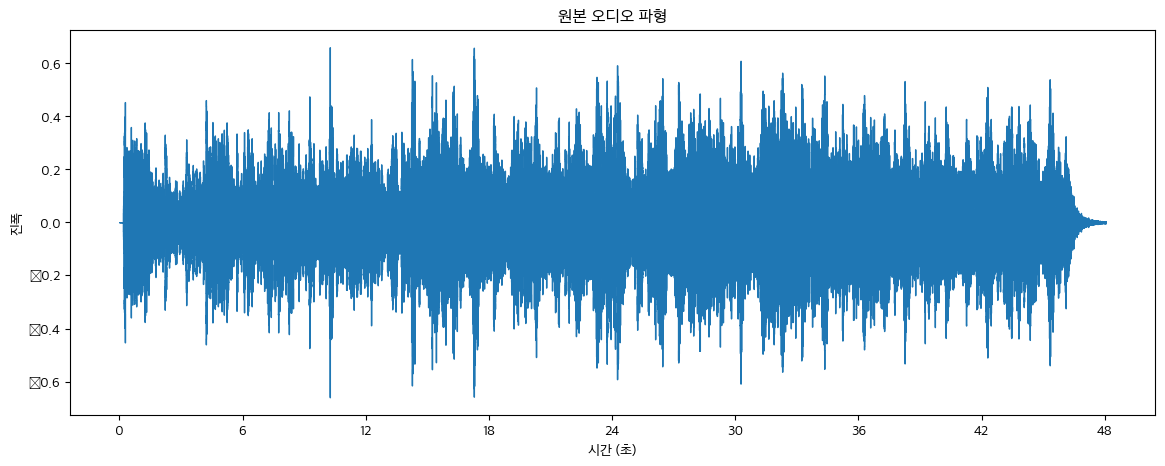

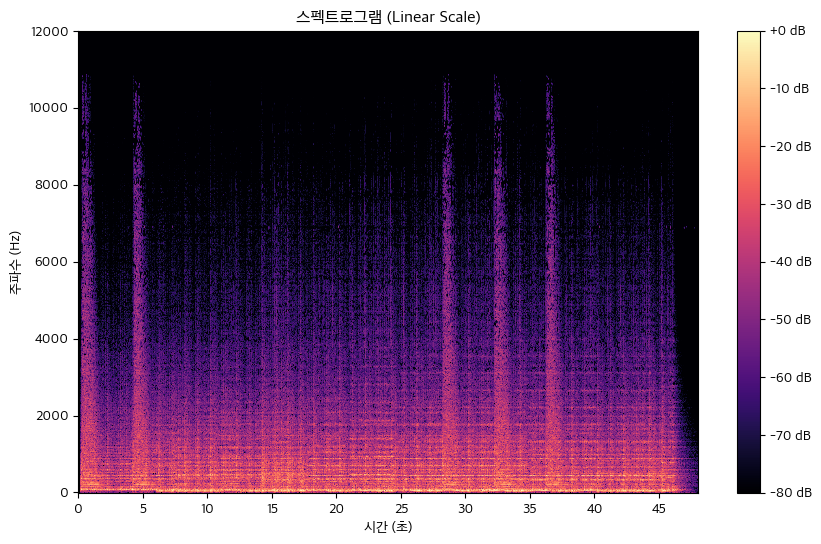

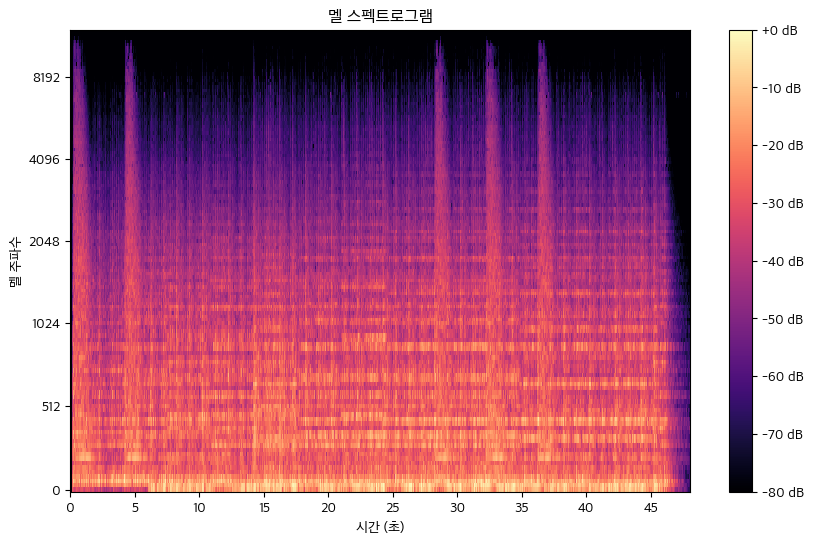

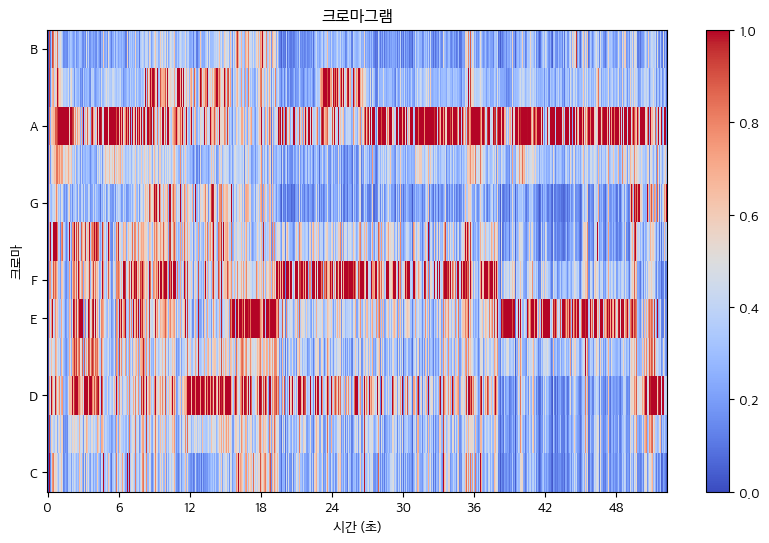

/var/folders/sv/jh_ctgn129b2zwq9rr41x8dr0000gn/T/ipykernel_38257/1923294242.py:78: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  plt.tight_layout()


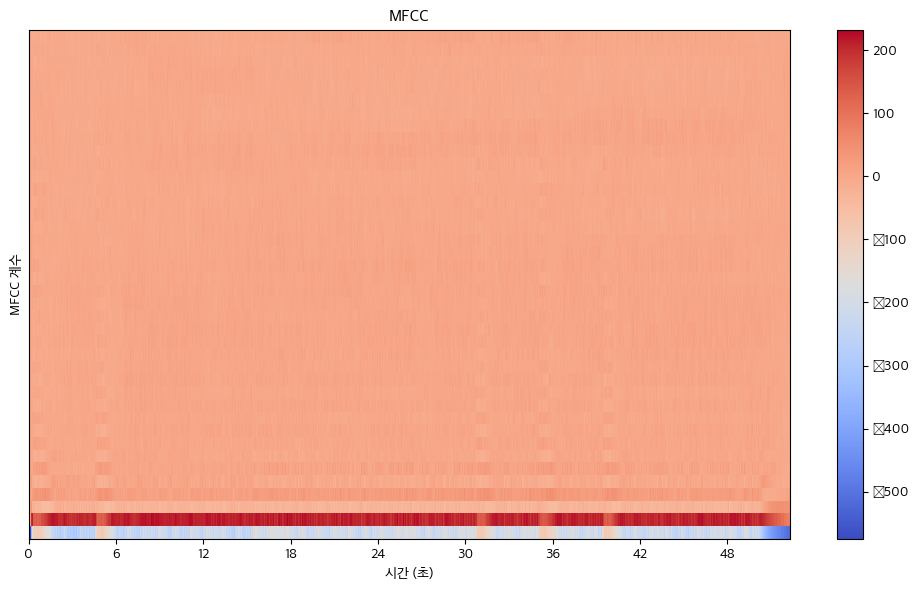

In [ ]:
# 입력 오디오 파일 경로 설정
audio_file_path = "../data/input_audio.wav"  # 예시 오디오 파일 경로

# 오디오 파일에서 특징 추출 및 시각화
print("오디오 파일에서 특징 추출 및 시각화 중...")
n_mfcc = 40
max_len = 174
mfcc = extract_features(audio_file_path, n_mfcc=n_mfcc, max_len=max_len, visualize=True)

In [10]:
# 입력 데이터 전처리
x = np.expand_dims(mfcc, axis=0)  # 채널 추가 (채널, 시간, 주파수)
x = np.expand_dims(x, axis=0)     # 배치 차원 추가 (배치 크기, 채널, 시간, 주파수)
x = x.transpose(0, 1, 3, 2)       # (배치 크기, 채널, 시간, 주파수)
x = torch.from_numpy(x).float().to(device)


In [11]:
# 모델 입력 형태 설정
input_shape = (1, n_mfcc, max_len)
num_classes = 1

# 각 악기에 대해 예측 수행
print("악기 예측 중...")
predictions = {}
for instrument in all_instruments:
    sanitized_instrument = sanitize_name(instrument)
    print(f" - {instrument}")
    # 모델 경로 설정
    model_path = os.path.join(models_output_dir, f"best_model_{sanitized_instrument}.pt")
    if not os.path.exists(model_path):
        print(f"   모델 파일이 존재하지 않습니다: {model_path}")
        continue
    # 모델 생성 및 로드
    model = CNNModel(input_shape, num_classes).to(device)
    model = load_model(model, model_path, device)
    model.eval()
    # 예측
    with torch.no_grad():
        output = model(x)
        pred = output.item()
        predictions[instrument] = pred


악기 예측 중...
 - clarinet
 - violin
 - cello
 - oboe
 - saxophone
 - double bass
 - clash cymbals
 - tuba


/var/folders/sv/jh_ctgn129b2zwq9rr41x8dr0000gn/T/ipykernel_38257/1923294242.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_

 - trumpet
 - flute
 - bass clarinet
 - french horn
 - bassoon
 - tambourine
 - viola
 - trombone



예측 결과:
clarinet: 0.0000 (없음)
violin: 0.0000 (없음)
cello: 0.0001 (없음)
oboe: 0.9969 (존재)
saxophone: 0.0000 (없음)
double bass: 1.0000 (존재)
clash cymbals: 1.0000 (존재)
tuba: 0.0000 (없음)
trumpet: 0.8360 (존재)
flute: 0.0000 (없음)
bass clarinet: 0.0000 (없음)
french horn: 0.0000 (없음)
bassoon: 0.8856 (존재)
tambourine: 0.0000 (없음)
viola: 0.0000 (없음)
trombone: 1.0000 (존재)


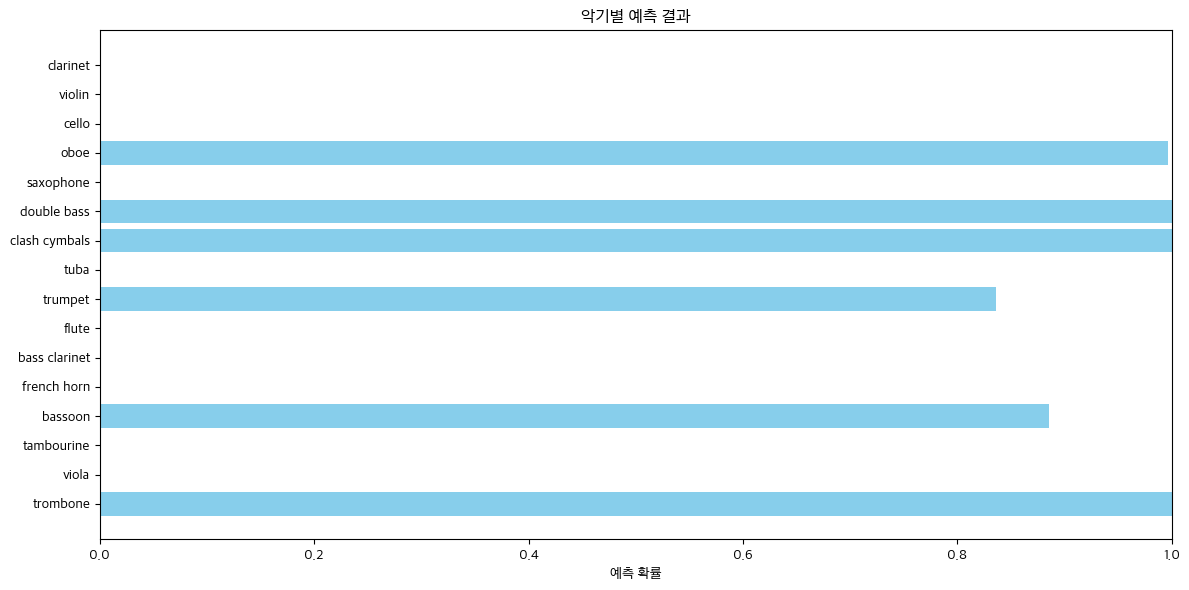

In [12]:
# 결과 출력
print("\n예측 결과:")
for instrument, score in predictions.items():
    print(f"{instrument}: {score:.4f} {'(존재)' if score > 0.5 else '(없음)'}")

# 예측 결과 시각화
instruments = list(predictions.keys())
scores = [predictions[instr] for instr in instruments]

plt.figure(figsize=(12, 6))
plt.barh(instruments, scores, color='skyblue')
plt.xlabel("예측 확률")
plt.title("악기별 예측 결과")
plt.gca().invert_yaxis()
plt.xlim(0, 1)
plt.tight_layout()
plt.show()
